In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from os.path import isdir, isfile, join
from random import randint, choice
import json
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [15, 10]

In [1]:
!pwd

/mnt/disk1/tvc_datasets/table_tennis/TTNet-Real-time-Analysis-System-for-Table-Tennis-Pytorch/dataset/training


In [11]:
"""
{
    "categories": [
        ...
        {
            "id": 2,
            "name": "cat",
            "supercategory": "animal"
        },
        ...
    ],
    "images": [
        {
            "id": 1,
            "file_name": "<filename0>.<ext>",
            "height": 480,
            "width": 640,
        },
        ...
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 1,
            "category_id": 2,
            "bbox": [260, 177, 231, 199],
            "score": 0.95,
            "area": 45969,
            "iscrowd": 0
        },
        ...
    ]
}

XYXY_ABS = 0
XYWH_ABS = 1

"""

categories = [
        {
            "id": 1,
            "name": "ball",
            "supercategory": "ball"
        },
]

base_path = '/mnt/disk1/tvc_datasets/table_tennis/TTNet-Real-time-Analysis-System-for-Table-Tennis-Pytorch/dataset/training/'
img_path = join(base_path, 'test/images')

img_id = 1
annot_id = 1

train_annotations = []
train_images = []

test_annotations = []
test_images = []

for i in range(1, 6):
    csv_path = f'annotations/game_{i}/extract_match{i}.csv'
    video_file = join(base_path, f'videos/game_{i}.mp4')
    vdo = cv2.VideoCapture(video_file)
    df = pd.read_csv(csv_path)
    total = len(df)

    pbar = tqdm(total=total)
    train_ratio = int(0.8*total)
    for j, item in df.iterrows():
        temp_img = {}
        temp_annot = {}
        img_is_background = True if item.x == -1 else False
        if img_is_background:
            continue
        # process image
        vdo.set(cv2.CAP_PROP_POS_FRAMES, item.frame_no+1)
        _, frame = vdo.retrieve()
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        name = f'match_{i}_frame_{item.frame_no}.png'
        
        # train/test separation
        if j < train_ratio:
            path = join('images/train', name)
            path_to_save = join(base_path, path)
        else:
            path = join('images/test', name)
            path_to_save = join(base_path, path)
        cv2.imwrite(path_to_save, frame)
        # process the image json
        temp_img = {
            'id': img_id,
            "file_name": path,
            "height": frame.shape[0],
            "width": frame.shape[1],
        }
        
        # train/test separation
        if j < train_ratio:
            train_images.append(temp_img)
        else:
            test_images.append(temp_img)
            
        # process the annotations
        x = int(item.x)
        y = int(item.y)
        x1 = x - 15
        y1 = y - 15
        w = 30
        h = 20
        img = cv2.rectangle(frame, (x1, y1), (x1+w, y1+h), (255, 0, 0), 2)
        temp_annot = {
            "id": annot_id,
            "image_id": img_id,
            "category_id": 1,
            "bbox": [x1, y1, w, h],
            "bbox_mode": 1,
            "area": w*h,
            "iscrowd": 0
        }

        # increment only when there exist the annotations
        annot_id += 1
        if j < train_ratio:
            train_annotations.append(temp_annot)
        else:
            test_annotations.append(temp_annot)
        break
                
        img_id += 1
        pbar.update(1)


  0%|                                                                                                                                                                    | 0/6799 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/6799 [00:00<?, ?it/s]

  0%|                                                                                                                                                                   | 0/17444 [00:00<?, ?it/s]


  0%|                                                                                                                                                                    | 0/7073 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/7406 [00:00<?, ?it/s]


In [12]:
train_js = {
    'images': train_images,
    'annotations': train_annotations,
    'categories': categories
}

test_js = {
    'images': test_images,
    'annotations': test_annotations,
    'categories': categories
   
}

json.dump(train_js, open('test/train.json', 'w'))
json.dump(test_js, open('test/test.json', 'w'))

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import cv2
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer
from detectron2.checkpoint import DetectionCheckpointer

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "test/train.json", ".")
register_coco_instances("my_dataset_val", {}, "test/test.json", ".")

[02/24 03:26:24 d2.data.datasets.coco]: Loaded 39 images in COCO format from test/train.json


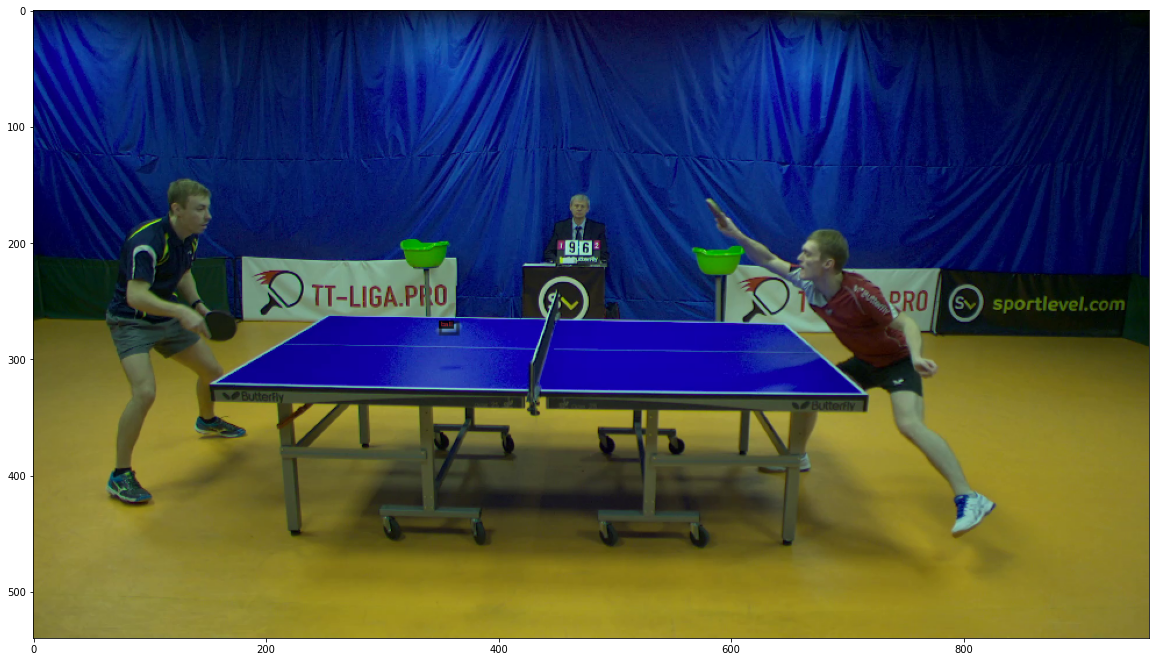

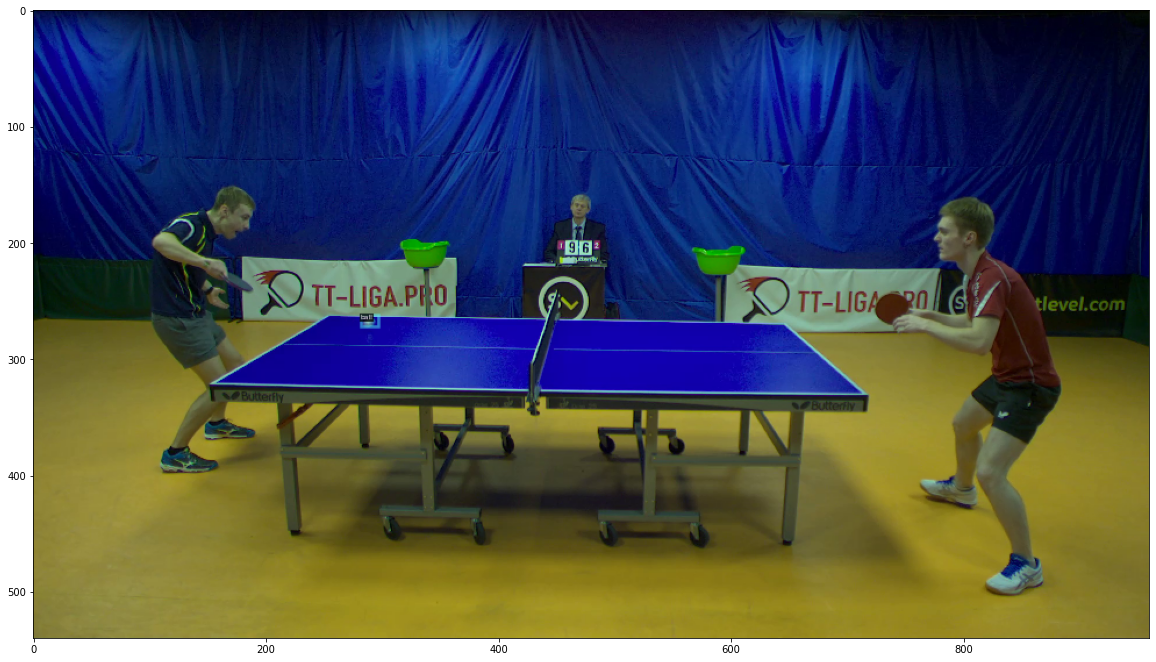

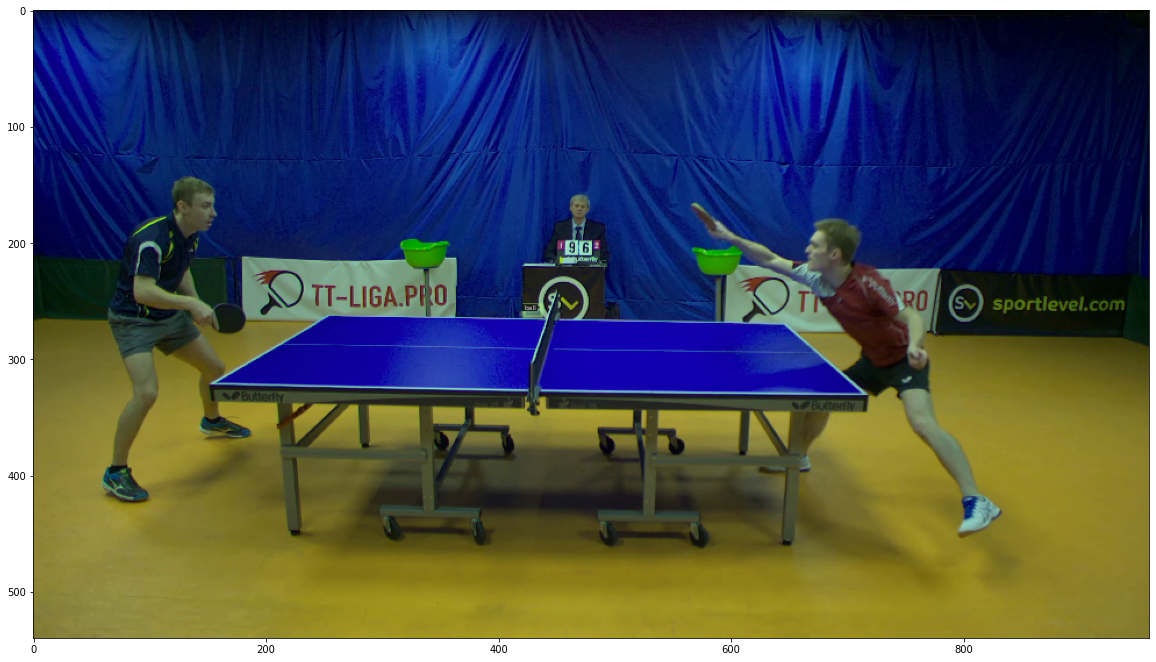

In [6]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img, metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())
    plt.show()

[02/24 03:26:35 d2.data.datasets.coco]: Loaded 11 images in COCO format from test/test.json


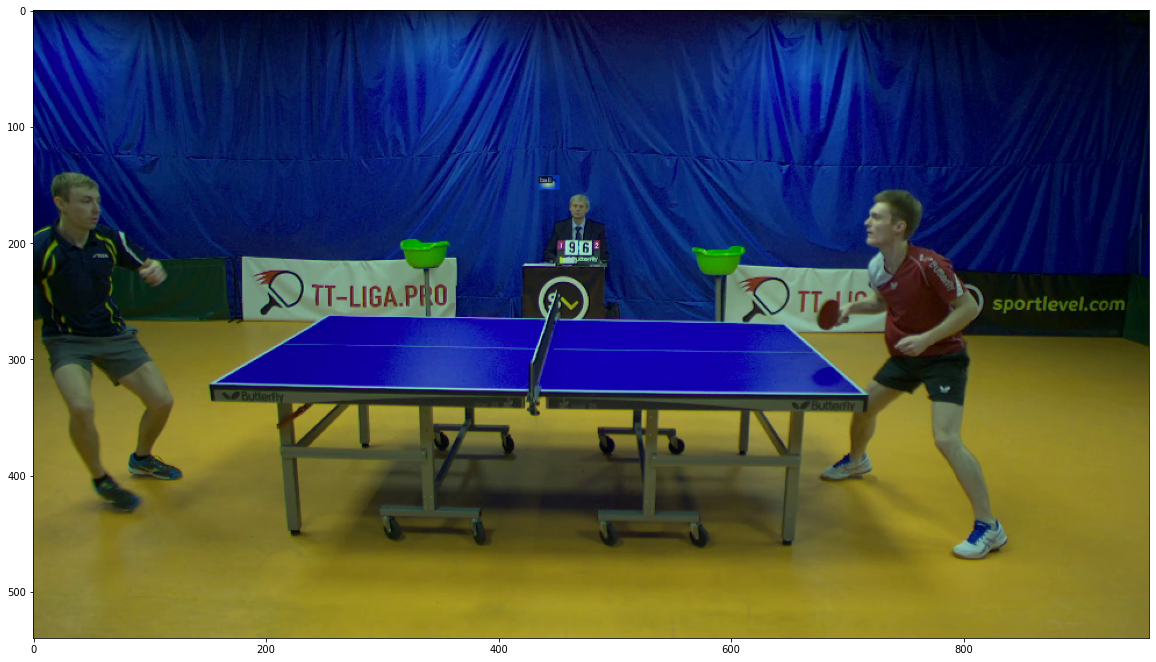

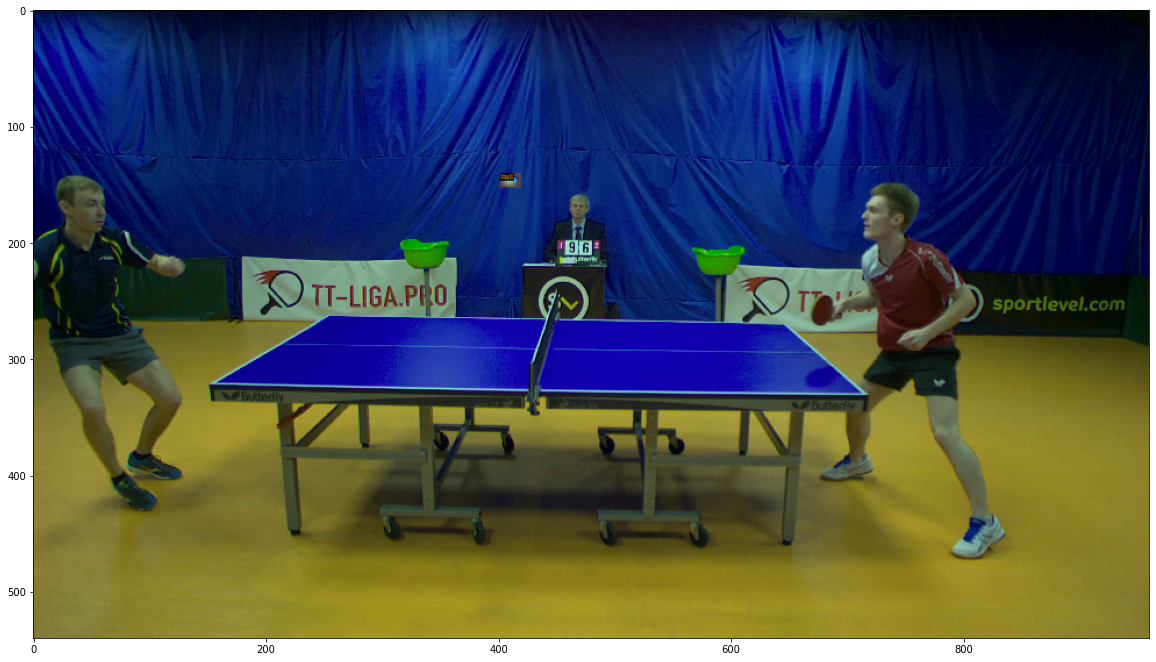

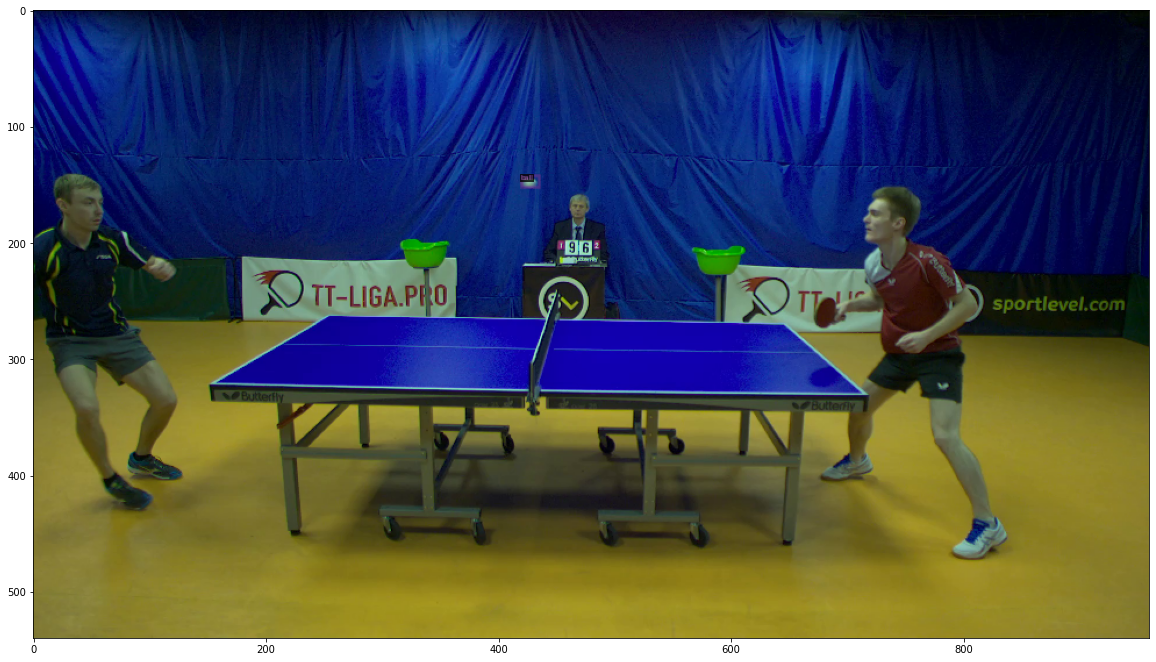

In [7]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_val")
dataset_dicts = DatasetCatalog.get("my_dataset_val")
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img, metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())
    plt.show()